# ***SVC***

## ***SVC LinearSVC***

In [1]:
import os
import time
import joblib
import numpy as np
import pandas as pd
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, label_binarize
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.svm import SVC
from sklearn.metrics import (
    f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, log_loss, roc_auc_score, roc_curve, auc
)
import optuna
from optuna.pruners import MedianPruner
import optuna.visualization as vis
import plotly.graph_objects as go
import lime.lime_tabular
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC



from reporte_metricas import ReporteMetricas
reporte = ReporteMetricas()

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [2]:

# =======================
# LOAD DATA
# =======================
file_path = "../Saber_pro_sampled_data.csv"
df = pd.read_csv(file_path)
X = df.drop(columns=["MOD_INGLES_DESEM"])
y = df["MOD_INGLES_DESEM"]

categorical_features = X.select_dtypes(include='object').columns.tolist()
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [3]:
le = LabelEncoder()
y = pd.Series(le.fit_transform(y), index=y.index)

class_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Class mapping:", class_mapping)

Class mapping: {'-A1': np.int64(0), 'A1': np.int64(1), 'A2': np.int64(2), 'B1': np.int64(3), 'B2': np.int64(4)}


In [4]:
# ============================
# FILE PATHS
# ============================
model_filename = "../Models/best_svc_model_lin.pkl"
study_filename = "../Study/optuna_study_SVC_nested_lin.pkl"
metrics_filename = "../Metrics/best_svc_metrics_lin.pkl"
fold_metrics_filename = "../Metrics/svc_folds_summary_lin.csv"

In [5]:
# ============================
# MODEL PIPELINE BUILDER
# ============================
def build_pipeline(params: dict, numeric_features: list, categorical_features: list):
    preprocessor = ColumnTransformer([
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), numeric_features),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="constant", fill_value="Sin Dato")),
            ("ohe", OneHotEncoder(handle_unknown="ignore", drop='first', sparse_output=False))
        ]), categorical_features)
    ],
    verbose_feature_names_out=False,
    force_int_remainder_cols=False
    )

    model = LinearSVC(
        **params,
        random_state=SEED,
        class_weight='balanced'
    )

    return Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", model)
    ])


In [6]:
# ============================
# MODEL EVALUATION
# ============================
def evaluate_model_sgd(model, X_data, y_data):
    y_pred = model.predict(X_data)
    #y_proba = model.predict_proba(X_data)
    f1 = f1_score(y_data, y_pred, average='weighted')
    acc = accuracy_score(y_data, y_pred)
    #loss = log_loss(y_data, y_proba)
    #auc = roc_auc_score(y_data, y_proba, multi_class='ovr', average='weighted')
    report = classification_report(y_data, y_pred)
    cm = confusion_matrix(y_data, y_pred)
    return f1, acc, report, cm, y_pred

# ============================
# CONFUSION MATRIX PLOTTER
# ============================
def plot_confusion_matrix(cm, labels, title):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format="d")
    disp.ax_.set_title(title)

In [7]:
# ============================
# OPTUNA INNER CV OPTIMIZATION
# ============================
def run_inner_optuna(X_inner, y_inner, numeric_features, categorical_features, n_trials=50):
    def objective(trial):
        params = {
            "C": trial.suggest_float("C", 1e-3, 100.0, log=True),
            "penalty": "l2",
            "dual": False,
            "max_iter": 1000,
            "tol": 1e-3
        }

        model = build_pipeline(params, numeric_features, categorical_features)
        skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)
        scores = []

        for train_idx, val_idx in skf.split(X_inner, y_inner):
            X_t, X_v = X_inner.iloc[train_idx], X_inner.iloc[val_idx]
            y_t, y_v = y_inner.iloc[train_idx], y_inner.iloc[val_idx]
            sample_weights = compute_sample_weight("balanced", y_t)
            model.fit(X_t, y_t, classifier__sample_weight=sample_weights)
            y_pred = model.predict(X_v)
            scores.append(f1_score(y_v, y_pred, average='weighted'))

        return np.mean(scores)

    study = optuna.create_study(direction="maximize", pruner=MedianPruner())
    study.optimize(objective, n_trials=n_trials, n_jobs=5)
    return study.best_params, study



In [8]:
# ============================
# SAVE FOLD METRICS
# ============================
def save_metrics_folds(folds_metrics: list, filename: str):
    df = pd.DataFrame(folds_metrics)
    resumen = df.describe().T[['mean', 'std']].reset_index()
    resumen.rename(columns={'index': 'metric'}, inplace=True)
    df_full = pd.concat([df, resumen], axis=0)
    df_full.to_csv(filename, index=False)
    return df, resumen

In [9]:
# ============================
# LIME EXPLAINER BUILDER
# ============================
def get_lime_explainer(model_pipeline, X_train_raw, y_train_raw):
    X_transformed = model_pipeline.named_steps['preprocessor'].transform(X_train_raw)
    feature_names = model_pipeline.named_steps['preprocessor'].get_feature_names_out()
    class_names = np.unique(y_train_raw).astype(str)
    explainer = lime.lime_tabular.LimeTabularExplainer(
        training_data=X_transformed,
        feature_names=feature_names,
        class_names=class_names,
        mode='classification'
    )
    return explainer, X_transformed

In [10]:
# ============================
# NESTED CV LOOP
# ============================
def nested_cv(X, y, numeric_features, categorical_features):
    visualizations = {}
    all_folds_metrics = []

    if os.path.exists(model_filename) and os.path.exists(metrics_filename):
        best_model = joblib.load(model_filename)
        best_metrics = joblib.load(metrics_filename)
        if "best_fold" in best_metrics:
            study_dt = joblib.load(study_filename)['studies'][best_metrics['best_fold']]
        else:
            study_dt = None
        if study_dt:
            visualizations['optimization_history'] = vis.plot_optimization_history(study_dt)
            visualizations['parallel_coordinate'] = vis.plot_parallel_coordinate(study_dt)
            visualizations['param_importances'] = vis.plot_param_importances(study_dt)
            f1_scores = [t.value for t in study_dt.trials]
            fig = go.Figure()
            fig.add_trace(go.Scatter(x=list(range(len(f1_scores))), y=f1_scores, mode='lines+markers', name='F1-score'))
            fig.update_layout(title='F1-Score Evolution During Optuna Optimization', xaxis_title='Trial', yaxis_title='F1-Score', template='plotly_dark')
            visualizations['f1_score_evolution'] = fig
        return best_model, best_metrics, study_dt, visualizations

    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    best_model, best_metrics = None, {}
    best_f1 = -np.inf
    optuna_studies = []
    best_fold = 1

    for fold, (train_idx, test_idx) in tqdm(
        enumerate(outer_cv.split(X, y), 1),
        total=outer_cv.get_n_splits(),
        desc = "Training folds"
    ):
        
        X_train_fold, X_test_fold = X.iloc[train_idx], X.iloc[test_idx]
        y_train_fold, y_test_fold = y.iloc[train_idx], y.iloc[test_idx]

        X_tr, X_val, y_tr, y_val = train_test_split(
                X_train_fold, y_train_fold,
                test_size=0.2, stratify=y_train_fold, random_state=SEED)

        start_time = time.time()
        best_params, study = run_inner_optuna(X_tr, y_tr, numeric_features, categorical_features)
        elapsed = time.time() - start_time
        optuna_studies.append(study)

        model = build_pipeline(best_params, numeric_features, categorical_features)
        model.fit(X_tr, y_tr)

        f1_train, acc_train, report_train, cm_train, y_train_pred = evaluate_model_sgd(model, X_tr, y_tr)
        f1_val, acc_val, report_val, cm_val, y_val_pred = evaluate_model_sgd(model, X_val, y_val)
        f1_test, acc_test, report_test, cm_test, y_test_pred = evaluate_model_sgd(model, X_test_fold, y_test_fold)

        fold_metrics = {
            "fold": fold,
            "f1_train": f1_train,
            "accuracy_train": acc_train,
            "log_loss_train": 999,
            "auc_train": 0,
            "f1_val": f1_val,
            "accuracy_val": acc_val,
            "log_loss_val": 999,
            "auc_val": 0,
            "f1_test": f1_test,
            "accuracy_test": acc_test,
            "log_loss_test":999,
            "auc_test": 0,
            "optuna_time": elapsed
        }
        all_folds_metrics.append(fold_metrics)

        if f1_test > best_f1:
            best_f1 = f1_test
            best_model = model
            best_metrics = {
                **fold_metrics,
                "params": best_params,
                "labels": np.unique(y),
                "best_fold": fold - 1,
                "X_train_fold": X_tr,
                "y_train_fold": y_tr,
                "y_train_pred": y_train_pred,
                "y_train_true": y_tr,
                #"y_proba_train": y_proba_train,
                "classification_report_train": report_train,
                "confusion_matrix_train": cm_train,
                "y_val_true": y_val,
                "y_val_pred": y_val_pred,
                #"y_proba_val": y_proba_val,
                "classification_report_val": report_val,
                "confusion_matrix_val": cm_val,
                "y_test_fold": y_test_fold,
                "y_test_pred": y_test_pred,
                #"y_proba_test": y_proba_test,
                "classification_report_test": report_test,
                "confusion_matrix_test": cm_test
            }

    joblib.dump(best_model, model_filename)
    joblib.dump({"studies": optuna_studies}, study_filename)
    joblib.dump(best_metrics, metrics_filename)
    save_metrics_folds(all_folds_metrics, fold_metrics_filename)

    study_dt = optuna_studies[best_metrics['best_fold']]
    visualizations['optimization_history'] = vis.plot_optimization_history(study_dt)
    visualizations['parallel_coordinate'] = vis.plot_parallel_coordinate(study_dt)
    visualizations['param_importances'] = vis.plot_param_importances(study_dt)

    f1_scores = [t.value for t in study_dt.trials]
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=list(range(len(f1_scores))), y=f1_scores, mode='lines+markers', name='F1-score'))
    fig.update_layout(title='F1-Score Evolution During Optuna Optimization', xaxis_title='Trial', yaxis_title='F1-Score', template='plotly_dark')
    visualizations['f1_score_evolution'] = fig

    return best_model, best_metrics, study_dt, visualizations


In [11]:
# Run pipeline
model, metrics, study, visualizations = nested_cv(X, y, numeric_features, categorical_features)

In [12]:
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  []),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='Sin '
                                                                                            'Dato',
                                                                                 strategy='constant')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=F...
                                                   'INST_ORIGEN', 'ESTU_GENERO',
                                                   'ESTU_NACIONALIDAD',
                                                   'ESTU_HORASSEMANATRABAJA',
                                                   'ESTU_PAGOMATRICULABECA',
                                                   'ESTU_PAGOMATRICULACREDITO',
                                                   'ESTU_PAGOMATRICULAPADRES',
                                                   'ESTU_PAGOMATRICULAPROPIO',
                                                   'ESTU_DEPTO_RESIDE',
                                                   'ESTU_DEPTO_PRESENTACION'])],
                                   verbose_feature_names_out=False)),
                ('classifier',
                 LinearSVC(C=0.1009645874298236, class_weight='balanced',
                           random_state=42))])

In [13]:
print(metrics['classification_report_val'])

              precision    recall  f1-score   support

           0       0.24      0.38      0.30      1523
           1       0.35      0.27      0.30      3457
           2       0.50      0.47      0.49      6269
           3       0.37      0.29      0.32      3585
           4       0.37      0.62      0.47      1645

    accuracy                           0.40     16479
   macro avg       0.37      0.41      0.37     16479
weighted avg       0.40      0.40      0.39     16479



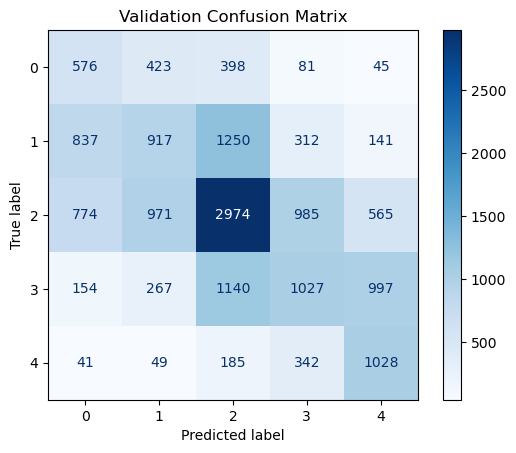

In [14]:
plot_confusion_matrix(metrics['confusion_matrix_val'], metrics['labels'], "Validation Confusion Matrix")

In [15]:
print(metrics['classification_report_test'])

              precision    recall  f1-score   support

           0       0.24      0.39      0.30      1904
           1       0.35      0.26      0.30      4321
           2       0.51      0.48      0.49      7836
           3       0.38      0.30      0.34      4481
           4       0.38      0.64      0.48      2056

    accuracy                           0.40     20598
   macro avg       0.37      0.41      0.38     20598
weighted avg       0.41      0.40      0.40     20598



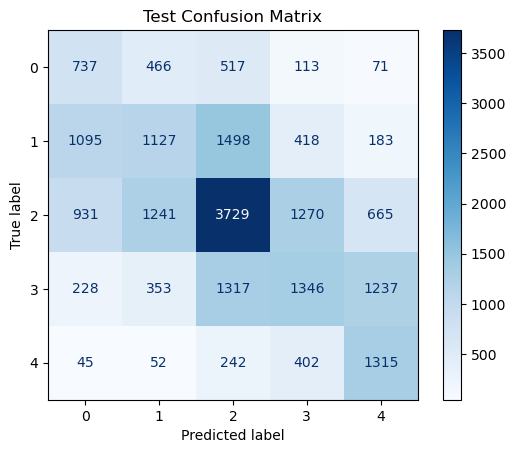

In [16]:
plot_confusion_matrix(metrics['confusion_matrix_test'], metrics['labels'], "Test Confusion Matrix")

In [17]:
visualizations['optimization_history']

In [18]:
visualizations['f1_score_evolution']

In [19]:
reporte.save(metrics, model_name="SVC_lin")


Report for model 'SVC_lin' saved:
   → CSV: ../Metrics/Metrics_SVC_lin.csv
   → JSON: ../Metrics/Metrics_SVC_lin.json


In [20]:
df1 = reporte.load()


Loaded 11 report(s):
   → Models: ['SVC_RFF', 'NB_Partial', 'SVC_lin', 'RF', 'SVC_SGD', 'Mult_NB', 'CART_SMOTE', 'Bern_NB', 'CART_ADASYN', 'RL', 'CART']
   → Types : ['train', 'val', 'test']


In [21]:
df1.query("Model == 'SVC_lin' and Type == 'train' and Class != 'global'").iloc[:, 0:6]

,Model,Type,Class,precision,recall,f1-score
48,SVC_lin,train,0,0.25,0.392,0.306
49,SVC_lin,train,1,0.359,0.266,0.306
50,SVC_lin,train,2,0.508,0.478,0.492
51,SVC_lin,train,3,0.379,0.295,0.332
52,SVC_lin,train,4,0.369,0.639,0.468
53,SVC_lin,train,macro avg,0.373,0.414,0.381
54,SVC_lin,train,weighted avg,0.411,0.402,0.399


In [22]:
df1.query("Model == 'SVC_lin' and Type == 'val' and Class != 'global'").iloc[:, 0:6]

,Model,Type,Class,precision,recall,f1-score
56,SVC_lin,val,0,0.242,0.378,0.295
57,SVC_lin,val,1,0.349,0.265,0.301
58,SVC_lin,val,2,0.5,0.474,0.487
59,SVC_lin,val,3,0.374,0.286,0.324
60,SVC_lin,val,4,0.37,0.625,0.465
61,SVC_lin,val,macro avg,0.367,0.406,0.375
62,SVC_lin,val,weighted avg,0.404,0.396,0.393


In [23]:
df1.query("Model == 'SVC_lin' and Type == 'test' and Class != 'global'").iloc[:, 0:6]


,Model,Type,Class,precision,recall,f1-score
64,SVC_lin,test,0,0.243,0.387,0.298
65,SVC_lin,test,1,0.348,0.261,0.298
66,SVC_lin,test,2,0.511,0.476,0.493
67,SVC_lin,test,3,0.379,0.3,0.335
68,SVC_lin,test,4,0.379,0.64,0.476
69,SVC_lin,test,macro avg,0.372,0.413,0.38
70,SVC_lin,test,weighted avg,0.41,0.401,0.398


In [24]:
df1.query("Model == 'SVC_lin' and auc != '-'")[["Model", "Type", "accuracy"]]


,Model,Type,accuracy
55,SVC_lin,train,0.402
63,SVC_lin,val,0.396
71,SVC_lin,test,0.401


In [25]:
df1.query("Model == 'SVC_lin' and Type == 'val' and Class	== 'global'")[["Model", "Type", "accuracy"]]

,Model,Type,accuracy
63,SVC_lin,val,0.396


In [26]:
model.named_steps['classifier'].get_params()

{'C': 0.1009645874298236,
 'class_weight': 'balanced',
 'dual': 'auto',
 'fit_intercept': True,
 'intercept_scaling': 1,
 'loss': 'squared_hinge',
 'max_iter': 1000,
 'multi_class': 'ovr',
 'penalty': 'l2',
 'random_state': 42,
 'tol': 0.0001,
 'verbose': 0}

## ***SVC RFF***

In [27]:
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.kernel_approximation import RBFSampler

In [28]:
# ============================
# FILE PATHS
# ============================
model_filename = "../Models/best_svc_model_rff.pkl"
study_filename = "../Study/optuna_study_SVC_nested_rff.pkl"
metrics_filename = "../Metrics/best_svc_metrics_rff.pkl"
fold_metrics_filename_rff = "../Metrics/svc_folds_summary_rff.csv"

In [29]:
# ============================
# MODEL PIPELINE BUILDER
# ============================
def build_pipeline(params: dict, numeric_features: list, categorical_features: list):
    preprocessor = ColumnTransformer([
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), numeric_features),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="constant", fill_value="Sin Dato")),
            ("ohe", OneHotEncoder(handle_unknown="ignore", drop='first', sparse_output=False))
        ]), categorical_features)
    ],
    verbose_feature_names_out=False,
    force_int_remainder_cols=False
    )

    rff = RBFSampler(
        gamma=params.pop("gamma_rff", 1.0),
        random_state=SEED
    )

    sgd = SGDClassifier(
        loss="hinge",
        random_state=SEED,
        class_weight='balanced',
        **params
    )

    model = Pipeline([
        ("rff", rff),
        ("sgd", sgd)
    ])

    return Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("classifier", model)
    ])


In [30]:
# ============================
# OPTUNA INNER CV OPTIMIZATION
# ============================
def run_inner_optuna(X_inner, y_inner, numeric_features, categorical_features, n_trials=50):
    def objective(trial):
        params = {
            "alpha": trial.suggest_float("alpha", 1e-6, 1e-2, log=True),
            "penalty": trial.suggest_categorical("penalty", ["l2"]),
            "gamma_rff": trial.suggest_float("gamma_rff", 0.01, 1.0, log=True),
            "max_iter": 1000,
            "tol": 1e-3
        }

        model = build_pipeline(params, numeric_features, categorical_features)
        skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)
        scores = []

        for train_idx, val_idx in skf.split(X_inner, y_inner):
            X_t, X_v = X_inner.iloc[train_idx], X_inner.iloc[val_idx]
            y_t, y_v = y_inner.iloc[train_idx], y_inner.iloc[val_idx]
            model.fit(X_t, y_t)
            y_pred = model.predict(X_v)
            scores.append(f1_score(y_v, y_pred, average='weighted'))

        return np.mean(scores)

    study = optuna.create_study(direction="maximize", pruner=MedianPruner())
    study.optimize(objective, n_trials=n_trials, n_jobs=5)
    return study.best_params, study


In [31]:
# ============================
# NESTED CV LOOP
# ============================
def nested_cv(X, y, numeric_features, categorical_features):
    visualizations = {}
    all_folds_metrics = []

    if os.path.exists(model_filename) and os.path.exists(metrics_filename):
        best_model = joblib.load(model_filename)
        best_metrics = joblib.load(metrics_filename)
        if "best_fold" in best_metrics:
            study_dt = joblib.load(study_filename)['studies'][best_metrics['best_fold']]
        else:
            study_dt = None
        if study_dt:
            visualizations['optimization_history'] = vis.plot_optimization_history(study_dt)
            visualizations['parallel_coordinate'] = vis.plot_parallel_coordinate(study_dt)
            visualizations['param_importances'] = vis.plot_param_importances(study_dt)
            f1_scores = [t.value for t in study_dt.trials]
            fig = go.Figure()
            fig.add_trace(go.Scatter(x=list(range(len(f1_scores))), y=f1_scores, mode='lines+markers', name='F1-score'))
            fig.update_layout(title='F1-Score Evolution During Optuna Optimization', xaxis_title='Trial', yaxis_title='F1-Score', template='plotly_dark')
            visualizations['f1_score_evolution'] = fig
        return best_model, best_metrics, study_dt, visualizations

    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    best_model, best_metrics = None, {}
    best_f1 = -np.inf
    optuna_studies = []
    best_fold = 1

    for fold, (train_idx, test_idx) in tqdm(
        enumerate(outer_cv.split(X, y), 1),
        total=outer_cv.get_n_splits(),
        desc = "Training folds"
    ):
        
        X_train_fold, X_test_fold = X.iloc[train_idx], X.iloc[test_idx]
        y_train_fold, y_test_fold = y.iloc[train_idx], y.iloc[test_idx]

        X_tr, X_val, y_tr, y_val = train_test_split(
                X_train_fold, y_train_fold,
                test_size=0.2, stratify=y_train_fold, random_state=SEED)

        start_time = time.time()
        best_params, study = run_inner_optuna(X_tr, y_tr, numeric_features, categorical_features)
        elapsed = time.time() - start_time
        optuna_studies.append(study)

        model = build_pipeline(best_params, numeric_features, categorical_features)
        model.fit(X_tr, y_tr)

        f1_train, acc_train, report_train, cm_train, y_train_pred = evaluate_model_sgd(model, X_tr, y_tr)
        f1_val, acc_val, report_val, cm_val, y_val_pred = evaluate_model_sgd(model, X_val, y_val)
        f1_test, acc_test, report_test, cm_test, y_test_pred = evaluate_model_sgd(model, X_test_fold, y_test_fold)

        fold_metrics = {
            "fold": fold,
            "f1_train": f1_train,
            "accuracy_train": acc_train,
            "log_loss_train": 999,
            "auc_train": 0,
            "f1_val": f1_val,
            "accuracy_val": acc_val,
            "log_loss_val": 999,
            "auc_val": 0,
            "f1_test": f1_test,
            "accuracy_test": acc_test,
            "log_loss_test":999,
            "auc_test": 0,
            "optuna_time": elapsed
        }
        all_folds_metrics.append(fold_metrics)

        if f1_test > best_f1:
            best_f1 = f1_test
            best_model = model
            best_metrics = {
                **fold_metrics,
                "params": best_params,
                "labels": np.unique(y),
                "best_fold": fold - 1,
                "X_train_fold": X_tr,
                "y_train_fold": y_tr,
                "y_train_pred": y_train_pred,
                "y_train_true": y_tr,
                #"y_proba_train": y_proba_train,
                "classification_report_train": report_train,
                "confusion_matrix_train": cm_train,
                "y_val_true": y_val,
                "y_val_pred": y_val_pred,
                #"y_proba_val": y_proba_val,
                "classification_report_val": report_val,
                "confusion_matrix_val": cm_val,
                "y_test_fold": y_test_fold,
                "y_test_pred": y_test_pred,
                #"y_proba_test": y_proba_test,
                "classification_report_test": report_test,
                "confusion_matrix_test": cm_test
            }

    joblib.dump(best_model, model_filename)
    joblib.dump({"studies": optuna_studies}, study_filename)
    joblib.dump(best_metrics, metrics_filename)
    save_metrics_folds(all_folds_metrics, fold_metrics_filename)

    study_dt = optuna_studies[best_metrics['best_fold']]
    visualizations['optimization_history'] = vis.plot_optimization_history(study_dt)
    visualizations['parallel_coordinate'] = vis.plot_parallel_coordinate(study_dt)
    visualizations['param_importances'] = vis.plot_param_importances(study_dt)

    f1_scores = [t.value for t in study_dt.trials]
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=list(range(len(f1_scores))), y=f1_scores, mode='lines+markers', name='F1-score'))
    fig.update_layout(title='F1-Score Evolution During Optuna Optimization', xaxis_title='Trial', yaxis_title='F1-Score', template='plotly_dark')
    visualizations['f1_score_evolution'] = fig

    return best_model, best_metrics, study_dt, visualizations


In [32]:
# Run pipeline
model, metrics, study, visualizations = nested_cv(X, y, numeric_features, categorical_features)

In [33]:
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  []),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='Sin '
                                                                                            'Dato',
                                                                                 strategy='constant')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=F...
                                                   'ESTU_PAGOMATRICULACREDITO',
                                                   'ESTU_PAGOMATRICULAPADRES',
                                                   'ESTU_PAGOMATRICULAPROPIO',
                                                   'ESTU_DEPTO_RESIDE',
                                                   'ESTU_DEPTO_PRESENTACION'])],
                                   verbose_feature_names_out=False)),
                ('classifier',
                 Pipeline(steps=[('rff',
                                  RBFSampler(gamma=0.015536029207049273,
                                             random_state=42)),
                                 ('sgd',
                                  SGDClassifier(alpha=2.2914212075432483e-05,
                                                class_weight='balanced',
                                                random_state=42))]))])

In [34]:
print(metrics['classification_report_train'])

              precision    recall  f1-score   support

           0       0.21      0.52      0.30      6090
           1       0.36      0.07      0.12     13827
           2       0.47      0.58      0.52     25076
           3       0.36      0.02      0.03     14340
           4       0.30      0.73      0.43      6580

    accuracy                           0.36     65913
   macro avg       0.34      0.38      0.28     65913
weighted avg       0.38      0.36      0.30     65913



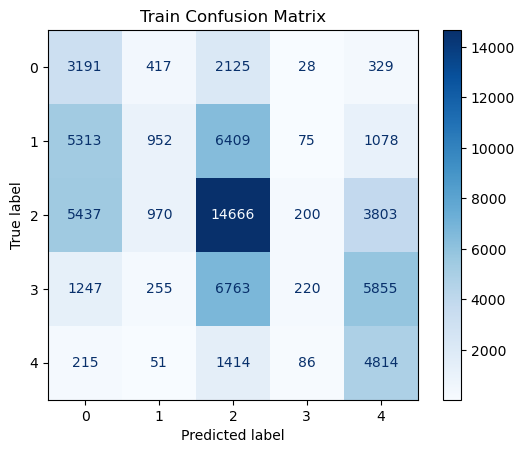

In [35]:
plot_confusion_matrix(metrics['confusion_matrix_train'], metrics['labels'], "Train Confusion Matrix")

In [36]:
print(metrics['classification_report_val'])

              precision    recall  f1-score   support

           0       0.21      0.53      0.30      1523
           1       0.35      0.07      0.11      3457
           2       0.46      0.58      0.52      6269
           3       0.36      0.01      0.03      3585
           4       0.30      0.72      0.43      1645

    accuracy                           0.36     16479
   macro avg       0.34      0.38      0.28     16479
weighted avg       0.38      0.36      0.30     16479



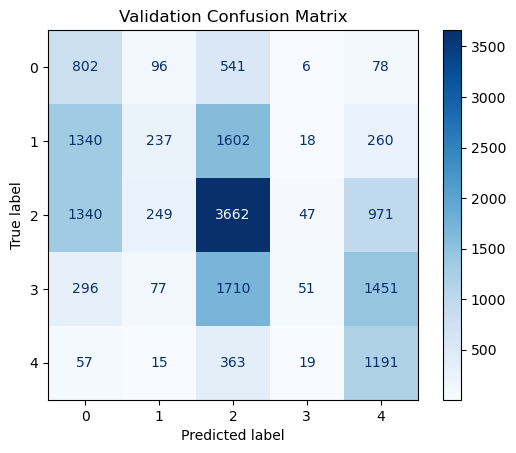

In [37]:
plot_confusion_matrix(metrics['confusion_matrix_val'], metrics['labels'], "Validation Confusion Matrix")

In [38]:
print(metrics['classification_report_test'])

              precision    recall  f1-score   support

           0       0.21      0.52      0.30      1903
           1       0.37      0.07      0.12      4321
           2       0.46      0.59      0.52      7836
           3       0.44      0.01      0.03      4482
           4       0.30      0.72      0.42      2056

    accuracy                           0.36     20598
   macro avg       0.36      0.38      0.28     20598
weighted avg       0.40      0.36      0.30     20598



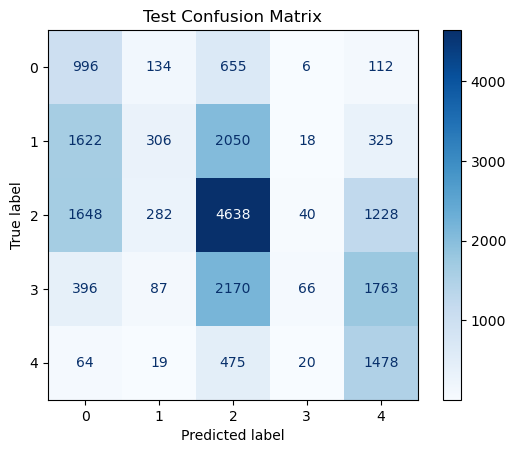

In [39]:
plot_confusion_matrix(metrics['confusion_matrix_test'], metrics['labels'], "Test Confusion Matrix")

In [40]:
visualizations['optimization_history']

In [41]:
visualizations['parallel_coordinate']

In [42]:
visualizations['f1_score_evolution']

In [43]:
visualizations['param_importances']

In [44]:
reporte.save(metrics, model_name="SVC_RFF")


Report for model 'SVC_RFF' saved:
   → CSV: ../Metrics/Metrics_SVC_RFF.csv
   → JSON: ../Metrics/Metrics_SVC_RFF.json


In [45]:
df2 = reporte.load()


Loaded 11 report(s):
   → Models: ['SVC_RFF', 'NB_Partial', 'SVC_lin', 'RF', 'SVC_SGD', 'Mult_NB', 'CART_SMOTE', 'Bern_NB', 'CART_ADASYN', 'RL', 'CART']
   → Types : ['train', 'val', 'test']


In [46]:
df2.query("Model == 'SVC_RFF' and Type == 'train' and Class != 'global'").iloc[:, 0:6]

,Model,Type,Class,precision,recall,f1-score
0,SVC_RFF,train,0,0.207,0.524,0.297
1,SVC_RFF,train,1,0.36,0.069,0.116
2,SVC_RFF,train,2,0.467,0.585,0.52
3,SVC_RFF,train,3,0.361,0.015,0.029
4,SVC_RFF,train,4,0.303,0.732,0.429
5,SVC_RFF,train,macro avg,0.34,0.385,0.278
6,SVC_RFF,train,weighted avg,0.381,0.362,0.299


In [47]:
df2.query("Model == 'SVC_RFF' and Type == 'val' and Class != 'global'").iloc[:, 0:6]

,Model,Type,Class,precision,recall,f1-score
8,SVC_RFF,val,0,0.209,0.527,0.299
9,SVC_RFF,val,1,0.352,0.069,0.115
10,SVC_RFF,val,2,0.465,0.584,0.518
11,SVC_RFF,val,3,0.362,0.014,0.027
12,SVC_RFF,val,4,0.301,0.724,0.426
13,SVC_RFF,val,macro avg,0.338,0.384,0.277
14,SVC_RFF,val,weighted avg,0.379,0.361,0.297


In [48]:
df2.query("Model == 'SVC_RFF' and Type == 'test' and Class != 'global'").iloc[:, 0:6]


,Model,Type,Class,precision,recall,f1-score
16,SVC_RFF,test,0,0.211,0.523,0.3
17,SVC_RFF,test,1,0.37,0.071,0.119
18,SVC_RFF,test,2,0.464,0.592,0.52
19,SVC_RFF,test,3,0.44,0.015,0.028
20,SVC_RFF,test,4,0.301,0.719,0.425
21,SVC_RFF,test,macro avg,0.357,0.384,0.279
22,SVC_RFF,test,weighted avg,0.399,0.363,0.299


In [49]:
df2.query("Model == 'SVC_RFF' and auc != '-'")[["Model", "Type", "accuracy", "log_loss", "auc"]]


,Model,Type,accuracy,log_loss,auc
7,SVC_RFF,train,0.362,999,0
15,SVC_RFF,val,0.361,999,0
23,SVC_RFF,test,0.363,999,0


In [50]:
df2.query("Model == 'SVC_RFF' and Type == 'val' and Class	== 'global'")[["Model", "Type", "accuracy"]]

,Model,Type,accuracy
15,SVC_RFF,val,0.361


In [51]:
model.named_steps['classifier'].get_params()

{'memory': None,
 'steps': [('rff', RBFSampler(gamma=0.015536029207049273, random_state=42)),
  ('sgd',
   SGDClassifier(alpha=2.2914212075432483e-05, class_weight='balanced',
                 random_state=42))],
 'verbose': False,
 'rff': RBFSampler(gamma=0.015536029207049273, random_state=42),
 'sgd': SGDClassifier(alpha=2.2914212075432483e-05, class_weight='balanced',
               random_state=42),
 'rff__gamma': 0.015536029207049273,
 'rff__n_components': 100,
 'rff__random_state': 42,
 'sgd__alpha': 2.2914212075432483e-05,
 'sgd__average': False,
 'sgd__class_weight': 'balanced',
 'sgd__early_stopping': False,
 'sgd__epsilon': 0.1,
 'sgd__eta0': 0.0,
 'sgd__fit_intercept': True,
 'sgd__l1_ratio': 0.15,
 'sgd__learning_rate': 'optimal',
 'sgd__loss': 'hinge',
 'sgd__max_iter': 1000,
 'sgd__n_iter_no_change': 5,
 'sgd__n_jobs': None,
 'sgd__penalty': 'l2',
 'sgd__power_t': 0.5,
 'sgd__random_state': 42,
 'sgd__shuffle': True,
 'sgd__tol': 0.001,
 'sgd__validation_fraction': 0.1,
 

## ***SVC SGD***

In [52]:
from sklearn.linear_model import SGDClassifier

In [53]:
# ============================
# FILE PATHS
# ============================
model_filename = "../Models/best_svc_model_sgd.pkl"
study_filename = "../Study/optuna_study_SVC_nested_sgd.pkl"
metrics_filename = "../Metrics/best_svc_metrics_sgd.pkl"
fold_metrics_filename_sgd = "../Metrics/svc_folds_summary_sgd.csv"

In [54]:
# ============================
# MODEL PIPELINE BUILDER
# ============================
def build_pipeline(params: dict, numeric_features: list, categorical_features: list):
    preprocessor = ColumnTransformer([
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), numeric_features),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="constant", fill_value="Sin Dato")),
            ("ohe", OneHotEncoder(handle_unknown="ignore", drop='first', sparse_output=False))
        ]), categorical_features)
    ],
    verbose_feature_names_out=False,
    force_int_remainder_cols=False
    )

    model = SGDClassifier(
        loss="hinge",
        random_state=SEED,
        class_weight='balanced',
        **params
    )

    return Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("classifier", model)
    ])


In [55]:
# ============================
# OPTUNA INNER CV OPTIMIZATION
# ============================
def run_inner_optuna(X_inner, y_inner, numeric_features, categorical_features, n_trials=50):
    def objective(trial):
        params = {
            "alpha": trial.suggest_float("alpha", 1e-6, 1e-2, log=True),
            "penalty": trial.suggest_categorical("penalty", ["l2", "l1", "elasticnet"]),
            "max_iter": 1000,
            "tol": 1e-3
        }

        model = build_pipeline(params, numeric_features, categorical_features)
        skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)
        scores = []

        for train_idx, val_idx in skf.split(X_inner, y_inner):
            X_t, X_v = X_inner.iloc[train_idx], X_inner.iloc[val_idx]
            y_t, y_v = y_inner.iloc[train_idx], y_inner.iloc[val_idx]
            sample_weights = compute_sample_weight("balanced", y_t)
            model.fit(X_t, y_t, classifier__sample_weight=sample_weights)
            y_pred = model.predict(X_v)
            scores.append(f1_score(y_v, y_pred, average='weighted'))

        return np.mean(scores)

    study = optuna.create_study(direction="maximize", pruner=MedianPruner())
    study.optimize(objective, n_trials=n_trials, n_jobs=5)
    return study.best_params, study


In [56]:
# ============================
# SAVE FOLD METRICS
# ============================
def save_metrics_folds(folds_metrics: list, filename: str):
    df = pd.DataFrame(folds_metrics)
    resumen = df.describe().T[['mean', 'std']].reset_index()
    resumen.rename(columns={'index': 'metric'}, inplace=True)
    df_full = pd.concat([df, resumen], axis=0)
    df_full.to_csv(filename, index=False)
    return df, resumen

In [57]:
# ============================
# LIME EXPLAINER BUILDER
# ============================
def get_lime_explainer(model_pipeline, X_train_raw, y_train_raw):
    X_transformed = model_pipeline.named_steps['preprocessor'].transform(X_train_raw)
    feature_names = model_pipeline.named_steps['preprocessor'].get_feature_names_out()
    class_names = np.unique(y_train_raw).astype(str)
    explainer = lime.lime_tabular.LimeTabularExplainer(
        training_data=X_transformed,
        feature_names=feature_names,
        class_names=class_names,
        mode='classification'
    )
    return explainer, X_transformed

In [58]:
# ============================
# NESTED CV LOOP
# ============================
def nested_cv(X, y, numeric_features, categorical_features):
    visualizations = {}
    all_folds_metrics = []

    if os.path.exists(model_filename) and os.path.exists(metrics_filename):
        best_model = joblib.load(model_filename)
        best_metrics = joblib.load(metrics_filename)
        if "best_fold" in best_metrics:
            study_dt = joblib.load(study_filename)['studies'][best_metrics['best_fold']]
        else:
            study_dt = None
        if study_dt:
            visualizations['optimization_history'] = vis.plot_optimization_history(study_dt)
            visualizations['parallel_coordinate'] = vis.plot_parallel_coordinate(study_dt)
            visualizations['param_importances'] = vis.plot_param_importances(study_dt)
            f1_scores = [t.value for t in study_dt.trials]
            fig = go.Figure()
            fig.add_trace(go.Scatter(x=list(range(len(f1_scores))), y=f1_scores, mode='lines+markers', name='F1-score'))
            fig.update_layout(title='F1-Score Evolution During Optuna Optimization', xaxis_title='Trial', yaxis_title='F1-Score', template='plotly_dark')
            visualizations['f1_score_evolution'] = fig
        return best_model, best_metrics, study_dt, visualizations

    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    best_model, best_metrics = None, {}
    best_f1 = -np.inf
    optuna_studies = []
    best_fold = 1

    for fold, (train_idx, test_idx) in tqdm(
        enumerate(outer_cv.split(X, y), 1),
        total=outer_cv.get_n_splits(),
        desc = "Training folds"
    ):
        
        X_train_fold, X_test_fold = X.iloc[train_idx], X.iloc[test_idx]
        y_train_fold, y_test_fold = y.iloc[train_idx], y.iloc[test_idx]

        X_tr, X_val, y_tr, y_val = train_test_split(
                X_train_fold, y_train_fold,
                test_size=0.2, stratify=y_train_fold, random_state=SEED)

        start_time = time.time()
        best_params, study = run_inner_optuna(X_tr, y_tr, numeric_features, categorical_features)
        elapsed = time.time() - start_time
        optuna_studies.append(study)

        model = build_pipeline(best_params, numeric_features, categorical_features)
        model.fit(X_tr, y_tr)

        f1_train, acc_train, report_train, cm_train, y_train_pred = evaluate_model_sgd(model, X_tr, y_tr)
        f1_val, acc_val, report_val, cm_val, y_val_pred = evaluate_model_sgd(model, X_val, y_val)
        f1_test, acc_test, report_test, cm_test, y_test_pred = evaluate_model_sgd(model, X_test_fold, y_test_fold)

        fold_metrics = {
            "fold": fold,
            "f1_train": f1_train,
            "accuracy_train": acc_train,
            "log_loss_train": 999,
            "auc_train": 0,
            "f1_val": f1_val,
            "accuracy_val": acc_val,
            "log_loss_val": 999,
            "auc_val": 0,
            "f1_test": f1_test,
            "accuracy_test": acc_test,
            "log_loss_test":999,
            "auc_test": 0,
            "optuna_time": elapsed
        }
        all_folds_metrics.append(fold_metrics)

        if f1_test > best_f1:
            best_f1 = f1_test
            best_model = model
            best_metrics = {
                **fold_metrics,
                "params": best_params,
                "labels": np.unique(y),
                "best_fold": fold - 1,
                "X_train_fold": X_tr,
                "y_train_fold": y_tr,
                "y_train_pred": y_train_pred,
                "y_train_true": y_tr,
                #"y_proba_train": y_proba_train,
                "classification_report_train": report_train,
                "confusion_matrix_train": cm_train,
                "y_val_true": y_val,
                "y_val_pred": y_val_pred,
                #"y_proba_val": y_proba_val,
                "classification_report_val": report_val,
                "confusion_matrix_val": cm_val,
                "y_test_fold": y_test_fold,
                "y_test_pred": y_test_pred,
                #"y_proba_test": y_proba_test,
                "classification_report_test": report_test,
                "confusion_matrix_test": cm_test
            }

    joblib.dump(best_model, model_filename)
    joblib.dump({"studies": optuna_studies}, study_filename)
    joblib.dump(best_metrics, metrics_filename)
    save_metrics_folds(all_folds_metrics, fold_metrics_filename)

    study_dt = optuna_studies[best_metrics['best_fold']]
    visualizations['optimization_history'] = vis.plot_optimization_history(study_dt)
    visualizations['parallel_coordinate'] = vis.plot_parallel_coordinate(study_dt)
    visualizations['param_importances'] = vis.plot_param_importances(study_dt)

    f1_scores = [t.value for t in study_dt.trials]
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=list(range(len(f1_scores))), y=f1_scores, mode='lines+markers', name='F1-score'))
    fig.update_layout(title='F1-Score Evolution During Optuna Optimization', xaxis_title='Trial', yaxis_title='F1-Score', template='plotly_dark')
    visualizations['f1_score_evolution'] = fig

    return best_model, best_metrics, study_dt, visualizations


In [59]:
# Run pipeline
model, metrics, study, visualizations = nested_cv(X, y, numeric_features, categorical_features)

In [60]:
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  []),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='Sin '
                                                                                            'Dato',
                                                                                 strategy='constant')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=F...
                                                   'ESTU_NACIONALIDAD',
                                                   'ESTU_HORASSEMANATRABAJA',
                                                   'ESTU_PAGOMATRICULABECA',
                                                   'ESTU_PAGOMATRICULACREDITO',
                                                   'ESTU_PAGOMATRICULAPADRES',
                                                   'ESTU_PAGOMATRICULAPROPIO',
                                                   'ESTU_DEPTO_RESIDE',
                                                   'ESTU_DEPTO_PRESENTACION'])],
                                   verbose_feature_names_out=False)),
                ('classifier',
                 SGDClassifier(alpha=2.8298425915790372e-06,
                               class_weight='balanced', penalty='elasticnet',
                               random_state=42))])

In [61]:
print(metrics['classification_report_val'])

              precision    recall  f1-score   support

           0       0.24      0.08      0.12      1523
           1       0.32      0.45      0.38      3457
           2       0.47      0.37      0.41      6269
           3       0.33      0.18      0.23      3585
           4       0.28      0.73      0.41      1645

    accuracy                           0.35     16479
   macro avg       0.33      0.36      0.31     16479
weighted avg       0.37      0.35      0.34     16479



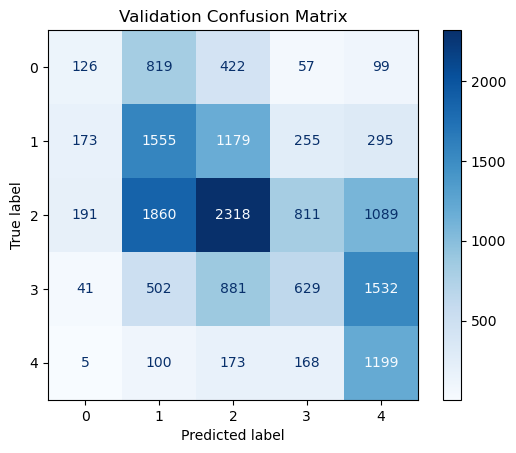

In [62]:
plot_confusion_matrix(metrics['confusion_matrix_val'], metrics['labels'], "Validation Confusion Matrix")

In [63]:
print(metrics['classification_report_test'])

              precision    recall  f1-score   support

           0       0.22      0.07      0.11      1904
           1       0.33      0.47      0.39      4321
           2       0.48      0.38      0.43      7836
           3       0.32      0.18      0.23      4481
           4       0.30      0.74      0.42      2056

    accuracy                           0.36     20598
   macro avg       0.33      0.37      0.32     20598
weighted avg       0.37      0.36      0.35     20598



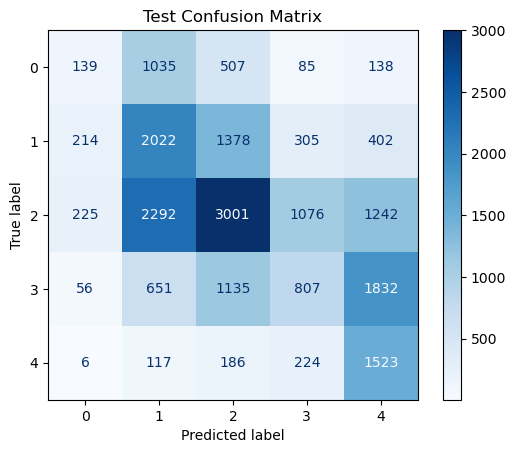

In [64]:
plot_confusion_matrix(metrics['confusion_matrix_test'], metrics['labels'], "Test Confusion Matrix")

In [65]:
visualizations['optimization_history']

In [66]:
visualizations['parallel_coordinate']

In [67]:
visualizations['f1_score_evolution']

In [68]:
visualizations['param_importances']

In [69]:
reporte.save(metrics, model_name="SVC_SGD")


Report for model 'SVC_SGD' saved:
   → CSV: ../Metrics/Metrics_SVC_SGD.csv
   → JSON: ../Metrics/Metrics_SVC_SGD.json


In [70]:
df3 = reporte.load()


Loaded 11 report(s):
   → Models: ['SVC_RFF', 'NB_Partial', 'SVC_lin', 'RF', 'SVC_SGD', 'Mult_NB', 'CART_SMOTE', 'Bern_NB', 'CART_ADASYN', 'RL', 'CART']
   → Types : ['train', 'val', 'test']


In [71]:
df3.query("Model == 'SVC_SGD' and Type == 'train' and Class != 'global'").iloc[:, 0:6]

,Model,Type,Class,precision,recall,f1-score
96,SVC_SGD,train,0,0.236,0.082,0.122
97,SVC_SGD,train,1,0.328,0.459,0.383
98,SVC_SGD,train,2,0.481,0.38,0.425
99,SVC_SGD,train,3,0.337,0.178,0.233
100,SVC_SGD,train,4,0.286,0.742,0.413
101,SVC_SGD,train,macro avg,0.334,0.368,0.315
102,SVC_SGD,train,weighted avg,0.376,0.361,0.345


In [72]:
df3.query("Model == 'SVC_SGD' and Type == 'val' and Class != 'global'").iloc[:, 0:6]

,Model,Type,Class,precision,recall,f1-score
104,SVC_SGD,val,0,0.235,0.083,0.122
105,SVC_SGD,val,1,0.322,0.45,0.375
106,SVC_SGD,val,2,0.466,0.37,0.412
107,SVC_SGD,val,3,0.328,0.175,0.229
108,SVC_SGD,val,4,0.285,0.729,0.409
109,SVC_SGD,val,macro avg,0.327,0.361,0.31
110,SVC_SGD,val,weighted avg,0.366,0.354,0.337


In [73]:
df3.query("Model == 'SVC_SGD' and Type == 'test' and Class != 'global'").iloc[:, 0:6]


,Model,Type,Class,precision,recall,f1-score
112,SVC_SGD,test,0,0.217,0.073,0.109
113,SVC_SGD,test,1,0.331,0.468,0.387
114,SVC_SGD,test,2,0.483,0.383,0.427
115,SVC_SGD,test,3,0.323,0.18,0.231
116,SVC_SGD,test,4,0.296,0.741,0.423
117,SVC_SGD,test,macro avg,0.33,0.369,0.316
118,SVC_SGD,test,weighted avg,0.373,0.364,0.347


In [74]:
df3.query("Model == 'SVC_SGD' and auc != '-'")[["Model", "Type", "accuracy"]]


,Model,Type,accuracy
103,SVC_SGD,train,0.361
111,SVC_SGD,val,0.354
119,SVC_SGD,test,0.364


In [75]:
df3.query("Model == 'SVC_SGD' and Type == 'val' and Class	== 'global'")[["Model", "Type", "accuracy"]]

,Model,Type,accuracy
111,SVC_SGD,val,0.354


In [76]:
model.named_steps['classifier'].get_params()

{'alpha': 2.8298425915790372e-06,
 'average': False,
 'class_weight': 'balanced',
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.0,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'optimal',
 'loss': 'hinge',
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'n_jobs': None,
 'penalty': 'elasticnet',
 'power_t': 0.5,
 'random_state': 42,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

## ***Comparación***

In [77]:
df1, df2, df3 = pd.read_csv(fold_metrics_filename), pd.read_csv(fold_metrics_filename_rff), pd.read_csv(fold_metrics_filename_sgd)
df1["modelo"] = "SVC_Linear"
df2["modelo"] = "SVC_RFF"
df3["modelo"] = "SVC_SGD"
df_full = pd.concat([df1, df2, df3], axis=0, ignore_index=True)
df_full.drop(columns=["log_loss_train","auc_train","log_loss_val","auc_val","log_loss_test" ,"auc_test"], inplace=True)
def highlight_model(row):
    color_map = {
        "SVC_Linear": "background-color: #D5F5E3",  
        "SVC_RFF": "background-color: #FADBD8", 
        "SVC_SGD": "background-color: #D6EAF8", 
    }
    return [color_map.get(row["modelo"], "")] * len(row)

df_full.style.apply(highlight_model, axis=1)

,fold,f1_train,accuracy_train,f1_val,accuracy_val,f1_test,accuracy_test,optuna_time,modelo
0,1.0,0.398937,0.401469,0.397614,0.400146,0.397215,0.400136,301.573689,SVC_Linear
1,2.0,0.397134,0.399800,0.394496,0.396505,0.393047,0.395281,537.222813,SVC_Linear
2,3.0,0.399476,0.402713,0.400081,0.402270,0.392054,0.394990,596.880531,SVC_Linear
3,4.0,0.399018,0.401893,0.388946,0.391225,0.390806,0.393873,596.824999,SVC_Linear
4,5.0,0.398533,0.401711,0.392725,0.395776,0.397964,0.400719,572.830035,SVC_Linear
5,mean,0.398620,0.401517,0.394772,0.397184,0.394217,0.397000,521.066414,SVC_Linear
6,std,0.000895,0.001068,0.004315,0.004260,0.003190,0.003179,125.104658,SVC_Linear
7,1.0,0.298553,0.361734,0.297133,0.360641,0.299259,0.363336,528.082164,SVC_RFF
8,2.0,0.247433,0.288668,0.242311,0.285636,0.248664,0.290756,436.259211,SVC_RFF
9,3.0,0.255777,0.382883,0.253941,0.382183,0.255117,0.381396,484.667111,SVC_RFF
